In [332]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [333]:
# Loading the data (from Jan 2009 to December 2020)
data = pd.read_csv('Tourism.csv', delimiter=';', header=1)

In [334]:
data.head(12)

,Year,Month,Canton,Visitors' country of residence - total Arrivals,Switzerland Arrivals,Baltic States Arrivals,Germany Arrivals,France Arrivals,Italy Arrivals,Austria Arrivals,...,United Arab Emirates Arrivals,Serbia and Montenegro Arrivals,Croatia Arrivals,Romania Arrivals,Russia Arrivals,Slovakia Arrivals,Slovenia Arrivals,Czechia Arrivals,Ukraine Arrivals,Serbia Arrivals
0,2009,January,Switzerland,1064111,528523,1250,154530,44363,38939,10142,...,...,919,963,1955,21566,644,638,1885,2623,...
1,2009,February,Switzerland,1089483,521069,864,160914,59787,35721,10615,...,...,779,728,1657,9881,920,595,2435,1328,...
2,2009,March,Switzerland,1196859,567431,1290,187297,55015,43895,14476,...,...,964,965,2010,13485,1123,780,3676,1839,...
3,2009,April,Switzerland,1045137,468308,1671,164642,48102,38747,13328,...,...,916,1010,1750,9139,1491,1073,3029,1341,...
4,2009,May,Switzerland,1214666,548389,1120,183987,52869,40187,16379,...,...,919,903,1638,13502,1014,847,3823,1690,...
5,2009,June,Switzerland,1446249,638139,1357,222239,56648,41357,19837,...,...,752,1364,2480,10201,949,1213,4119,1627,...
6,2009,July,Switzerland,1821751,805722,2264,251183,73066,49518,21200,...,...,611,728,3964,12487,1389,1032,4669,1946,...
7,2009,August,Switzerland,1876038,834422,2328,292899,84149,81086,25317,...,...,790,1054,5440,13107,1288,1192,5573,2156,...
8,2009,September,Switzerland,1621888,789269,1389,248366,60379,44028,20758,...,...,795,961,2702,10916,1024,1245,4220,1624,...
9,2009,October,Switzerland,1267800,658074,1007,171685,51764,40245,14019,...,...,859,945,2175,10205,748,1068,2472,1477,...


In [335]:
#Reindexing
data.index = pd.date_range('2009-01-01', '2020-12-01', freq= 'MS')

In [336]:
#Drop useless columns
data = data.drop(['Year', 'Month', 'Canton'], axis = 1)

In [337]:
data

,Visitors' country of residence - total Arrivals,Switzerland Arrivals,Baltic States Arrivals,Germany Arrivals,France Arrivals,Italy Arrivals,Austria Arrivals,United Kingdom Arrivals,Irland Arrivals,Netherlands Arrivals,...,United Arab Emirates Arrivals,Serbia and Montenegro Arrivals,Croatia Arrivals,Romania Arrivals,Russia Arrivals,Slovakia Arrivals,Slovenia Arrivals,Czechia Arrivals,Ukraine Arrivals,Serbia Arrivals
2009-01-01,1064111,528523,1250,154530,44363,38939,10142,53636,2662,20687,...,...,919,963,1955,21566,644,638,1885,2623,...
2009-02-01,1089483,521069,864,160914,59787,35721,10615,65594,2880,39239,...,...,779,728,1657,9881,920,595,2435,1328,...
2009-03-01,1196859,567431,1290,187297,55015,43895,14476,61323,2744,24138,...,...,964,965,2010,13485,1123,780,3676,1839,...
2009-04-01,1045137,468308,1671,164642,48102,38747,13328,48590,2446,20859,...,...,916,1010,1750,9139,1491,1073,3029,1341,...
2009-05-01,1214666,548389,1120,183987,52869,40187,16379,51515,2253,25541,...,...,919,903,1638,13502,1014,847,3823,1690,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,1525425,1079180,...,163293,85633,33407,15560,24403,916,40299,...,1138,...,498,1594,1723,838,626,3533,557,315
2020-09-01,1291992,1004036,...,125323,38504,22087,11173,9089,713,25481,...,951,...,245,1039,1810,616,483,1431,405,420
2020-10-01,949466,796811,...,58462,28479,16028,5099,4061,431,3689,...,549,...,263,1104,1451,376,244,334,292,283
2020-11-01,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [338]:
#Replacing '...' values by 0 and Converting arrival string values into integer values
for column in data.columns:
    data[column] = data[column].apply(lambda x : 0 if x == '...' else float(x))

In [339]:
data

,Visitors' country of residence - total Arrivals,Switzerland Arrivals,Baltic States Arrivals,Germany Arrivals,France Arrivals,Italy Arrivals,Austria Arrivals,United Kingdom Arrivals,Irland Arrivals,Netherlands Arrivals,...,United Arab Emirates Arrivals,Serbia and Montenegro Arrivals,Croatia Arrivals,Romania Arrivals,Russia Arrivals,Slovakia Arrivals,Slovenia Arrivals,Czechia Arrivals,Ukraine Arrivals,Serbia Arrivals
2009-01-01,1064111.0,528523.0,1250.0,154530.0,44363.0,38939.0,10142.0,53636.0,2662.0,20687.0,...,0.0,919.0,963.0,1955.0,21566.0,644.0,638.0,1885.0,2623.0,0.0
2009-02-01,1089483.0,521069.0,864.0,160914.0,59787.0,35721.0,10615.0,65594.0,2880.0,39239.0,...,0.0,779.0,728.0,1657.0,9881.0,920.0,595.0,2435.0,1328.0,0.0
2009-03-01,1196859.0,567431.0,1290.0,187297.0,55015.0,43895.0,14476.0,61323.0,2744.0,24138.0,...,0.0,964.0,965.0,2010.0,13485.0,1123.0,780.0,3676.0,1839.0,0.0
2009-04-01,1045137.0,468308.0,1671.0,164642.0,48102.0,38747.0,13328.0,48590.0,2446.0,20859.0,...,0.0,916.0,1010.0,1750.0,9139.0,1491.0,1073.0,3029.0,1341.0,0.0
2009-05-01,1214666.0,548389.0,1120.0,183987.0,52869.0,40187.0,16379.0,51515.0,2253.0,25541.0,...,0.0,919.0,903.0,1638.0,13502.0,1014.0,847.0,3823.0,1690.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,1525425.0,1079180.0,0.0,163293.0,85633.0,33407.0,15560.0,24403.0,916.0,40299.0,...,1138.0,0.0,498.0,1594.0,1723.0,838.0,626.0,3533.0,557.0,315.0
2020-09-01,1291992.0,1004036.0,0.0,125323.0,38504.0,22087.0,11173.0,9089.0,713.0,25481.0,...,951.0,0.0,245.0,1039.0,1810.0,616.0,483.0,1431.0,405.0,420.0
2020-10-01,949466.0,796811.0,0.0,58462.0,28479.0,16028.0,5099.0,4061.0,431.0,3689.0,...,549.0,0.0,263.0,1104.0,1451.0,376.0,244.0,334.0,292.0,283.0
2020-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


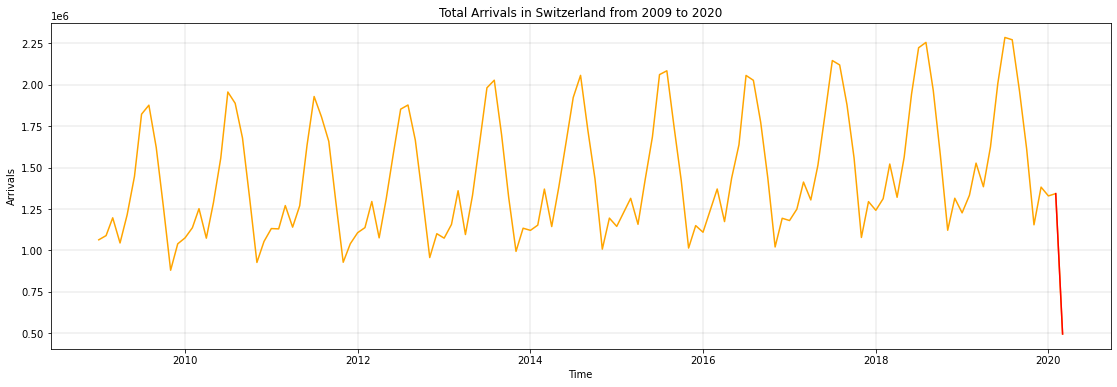

In [340]:
#Plot total number of Arrivals from Jan 2009 to March 2020 (Lockdown in Switzerland)
plt.figure(figsize= (19,6 ))
plt.plot(data[:datetime(2020,3,1)].index, data["Visitors' country of residence - total Arrivals"][:datetime(2020,3,1)], color = 'orange')
plt.plot(data[datetime(2020,2,1):datetime(2020,3,1)].index, data["Visitors' country of residence - total Arrivals"][datetime(2020,2,1):datetime(2020,3,1)], color = 'r')
plt.title('Total Arrivals in Switzerland from 2009 to 2020')
plt.xlabel('Time')
plt.ylabel('Arrivals')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

In [409]:
Arrivals = pd.DataFrame(data["Visitors' country of residence - total Arrivals"])
Arrivals = Arrivals.rename(columns = {"Visitors' country of residence - total Arrivals": 'Total Arrivals'}, inplace = False)
#Arrivals['Total Arrivals'] = Arrivals['Total Arrivals'].apply(lambda x : np.log(x) if x>0 else 0)

In [410]:
Arrivals

,Total Arrivals
2009-01-01,1064111.0
2009-02-01,1089483.0
2009-03-01,1196859.0
2009-04-01,1045137.0
2009-05-01,1214666.0
...,...
2020-08-01,1525425.0
2020-09-01,1291992.0
2020-10-01,949466.0
2020-11-01,0.0


## AR Base Modelisation

In [411]:
#Covid crisis for our testSet
start_date_testing = datetime(2015,3,1)
end_date_testing = datetime(2020,10,1)

ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values: it describes how well the present value of the series is related with its past values.


PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. For example, if we are regressing a variable Y on other variables X1, X2, and X3, the partial correlation between Y and X3 is the amount of correlation between Y and X3 that is not explained by their common correlations with X1 and X2.

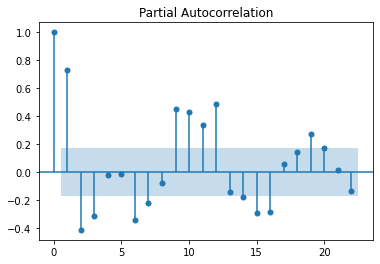

In [412]:
pacf = plot_pacf(Arrivals['Total Arrivals'][:start_date_covid_crisis])

We observe a significant partial correlation with variables t-1, t-2, t-3, t-9, t-10 and t-12

In [413]:
delays = [1, 2, 3, 9, 10, 12]

In [414]:
for i in delays:
    Arrivals['t-{}'.format(i)] = Arrivals['Total Arrivals'].shift(i)

In [415]:
Arrivals

,Total Arrivals,t-1,t-2,t-3,t-9,t-10,t-12
2009-01-01,1064111.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-01,1089483.0,1064111.0,NaN,NaN,NaN,NaN,NaN
2009-03-01,1196859.0,1089483.0,1064111.0,NaN,NaN,NaN,NaN
2009-04-01,1045137.0,1196859.0,1089483.0,1064111.0,NaN,NaN,NaN
2009-05-01,1214666.0,1045137.0,1196859.0,1089483.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-08-01,1525425.0,1539928.0,716421.0,307372.0,1154630.0,1612160.0,2270490.0
2020-09-01,1291992.0,1525425.0,1539928.0,716421.0,1381913.0,1154630.0,1958831.0
2020-10-01,949466.0,1291992.0,1525425.0,1539928.0,1328894.0,1381913.0,1612160.0
2020-11-01,0.0,949466.0,1291992.0,1525425.0,1342777.0,1328894.0,1154630.0


In [416]:
Arrivals = Arrivals.dropna(axis=0)

In [417]:
Arrivals

,Total Arrivals,t-1,t-2,t-3,t-9,t-10,t-12
2010-01-01,1075731.0,1039895.0,880617.0,1267800.0,1045137.0,1196859.0,1064111.0
2010-02-01,1136889.0,1075731.0,1039895.0,880617.0,1214666.0,1045137.0,1089483.0
2010-03-01,1251923.0,1136889.0,1075731.0,1039895.0,1446249.0,1214666.0,1196859.0
2010-04-01,1074035.0,1251923.0,1136889.0,1075731.0,1821751.0,1446249.0,1045137.0
2010-05-01,1287452.0,1074035.0,1251923.0,1136889.0,1876038.0,1821751.0,1214666.0
...,...,...,...,...,...,...,...
2020-08-01,1525425.0,1539928.0,716421.0,307372.0,1154630.0,1612160.0,2270490.0
2020-09-01,1291992.0,1525425.0,1539928.0,716421.0,1381913.0,1154630.0,1958831.0
2020-10-01,949466.0,1291992.0,1525425.0,1539928.0,1328894.0,1381913.0,1612160.0
2020-11-01,0.0,949466.0,1291992.0,1525425.0,1342777.0,1328894.0,1154630.0


In [418]:
True_Arrivals = Arrivals['Total Arrivals'][start_date_testing : end_date_testing]

In [419]:
#Implementation of the Linear Regression model with or without the Google Trends features, with a training window increasing at every iteration

def Auto_Regressive_Model(True_Labels, end_date_testing, dataset):
    
    Arrivals_Predictions = True_Labels.copy()

    for train_last in True_Arrivals.index:
        train = dataset[ :train_last -timedelta(days=1)]
        test = dataset[train_last : end_date_testing]
    
        y_train = train['Total Arrivals'].values
        X_train = train.drop(['Total Arrivals', 't-9', 't-10'], axis = 1).values
            #print(X_train)
        y_test = test['Total Arrivals'].values
        X_test = test.drop(['Total Arrivals', 't-9', 't-10'], axis = 1).values
    
        lr = LinearRegression()
    
        lr.fit(X_train, y_train)
     
        if(train_last==start_date_testing):
            print('The intercept value is:', lr.intercept_ )
            print('The final estimation of lag(y,-1) is: {}'.format(lr.coef_[0]))
            print('The final estimation of lag(y,-2) is: {}'.format(lr.coef_[1]))
            print('The final estimation of lag(y,-3) is: {}'.format(lr.coef_[2]))
            print('The final estimation of lag(y,-12) is: {}'.format(lr.coef_[3]))
           

        pred = lr.predict(X_test)
    
        Arrivals_Predictions[train_last] = pred[0]
        
    MAE = mean_absolute_error(True_Labels, Arrivals_Predictions)
    print("MAE :{}".format(MAE) )
    return Arrivals_Predictions, MAE

In [420]:
Baseline_Arrivals_Predictions, Baseline_MAE = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals)

The intercept value is: 39027.15328575391
The final estimation of lag(y,-1) is: -0.0002119004001242722
The final estimation of lag(y,-2) is: 0.02525964990564189
The final estimation of lag(y,-3) is: -0.018757973808978583
The final estimation of lag(y,-12) is: 0.9850404274052736
MAE :119038.54713733417


In [421]:
Arrivals_Predictions

2015-03-01    14.148232
2015-04-01    13.973686
2015-05-01    14.159760
2015-06-01    14.328129
2015-07-01    14.481690
                ...    
2020-06-01    15.097278
2020-07-01    14.390032
2020-08-01    14.623903
2020-09-01    14.345458
2020-10-01    14.126106
Freq: MS, Name: Total Arrivals, Length: 68, dtype: float64

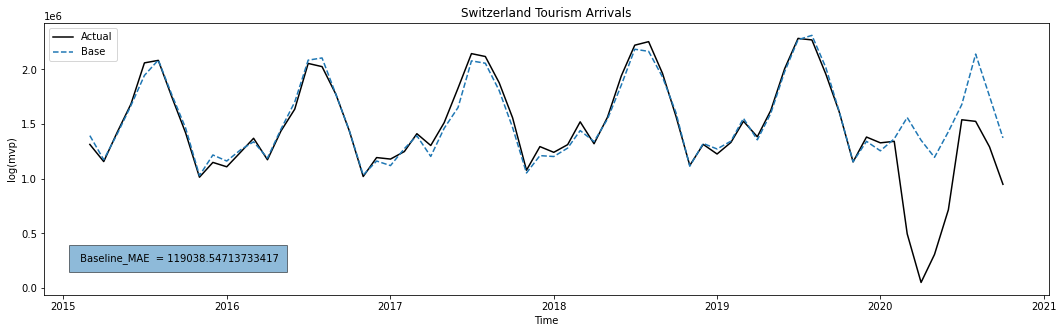

In [425]:
# I plot the result of the increasing size rolling window: It is the exact same graph obtained in the paper
fig,axes = plt.subplots(figsize=(18,5))

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions, linestyle='dashed', label='Base')


plt.text('2015-02-01', 0.25*1e6, ' Baseline_MAE  = {}'.format(Baseline_MAE), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('log(mvp)')
plt.title('Switzerland Tourism Arrivals')
plt.legend()